Domingo, Kenneth V.<br />
2015-03116<br />
Video and Image Processing Group, Instrumentation Physics Laboratory

\textbf{References}:

[1] Zhou, N., Pan, S., Cheng, S., and Zhou, Z. (2016). Image compression-encryption scheme based on hyper-chaotic system and 2D compressive sensing. <i>Optics and laser tech. <b>82</b></i>: 121-133.

[2] Mo, Y., Zhang, A., Zheng, F., and Zhou, N. (2013). An image compression-encryption algorithm based on 2-D compressive sensing. <i>Journ. of Computational Info. Systems <b>9</b></i>(24): 10057-10064.

[3] Mohimani, H., Babaie-Zadeh, M., and Jutten, C. (2008). A fast approach for overcomplete sparse decomposition based on smoothed L0 norm. <i>IEEE Trans. on Signal Processing <b>57</b></i>(1): 289-301. arXiv:0809.2508v2.

In [1]:
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D
import scipy.fftpack as fft
import scipy.ndimage as img
import scipy.linalg as la
from itertools import combinations
from jupyterthemes import jtplot
from copy import deepcopy

In [2]:
jtplot.reset()
mp.switch_backend("TkAgg")
mp.style.use("fast")
mp.rcParams["text.usetex"] = True
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["font.family"] = "serif"

In [3]:
class rksolve:
    
    def __init__(self, f):
        self.f = f
        self.init_conds = None
        self.solution = None
        
    def rk4(self, ta, tb, N=1000):
        f = self.f
        r0 = np.array(self.init_conds, float)
        s = (tb - ta)/N
        tpoints = np.arange(ta,tb,s)
        solution = np.zeros(tpoints.shape + r0.shape, float)
        r = r0
        for i,t in enumerate(tpoints):
            solution[i] = r
            k1 = s*f(r,t)
            k2 = s*f(r + 1/2*k1, t + 1/2*s)
            k3 = s*f(r + 1/2*k2, t + 1/2*s)
            k4 = s*f(r + k3, t + s)
            r += 1/6*(k1 + 2*k2 + 2*k3 + k4)
        self.s = s
        self.solution = solution
        self.t = tpoints
        
def chen_chaos(alpha, beta, gamma, delta, kappa):

    def f(r,t):
        x,y,z,h = r
        dx = alpha * (y - x)
        dy = delta*x - x*z + gamma*y - h
        dz = x*y - beta*z
        dh = x + kappa
        return np.array([dx, dy, dz, dh], float)
    
    chen = rksolve(f)
    r0 = np.array([0.3, 0.4, 0.5, 0.6], float)
    chen.init_conds = r0
    chen.rk4(0, 50, 10000)
    x,y,z,h = chen.solution[:,0], chen.solution[:,1], chen.solution[:,2], chen.solution[:,3]
    return x,y,z,h

def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho').T, norm='ortho')

In [4]:
xi,yi,zi,hi = chen_chaos(36, 3, 28, -16, 0.2)
Z = np.array([xi,yi,zi,hi])
# np.savetxt("Experiment/Hyperchaos 2DCS/chaos_sequence.txt", Z)
# xi, yi, zi, hi = np.loadtxt("Experiment/Hyperchaos 2DCS/chaos_sequence.txt")

In [13]:
def run_anim():
    fig = mp.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_zlim(0, 30)
    ax.view_init(30, 0)
    ax.axis("off")
    ax.grid(False)
    xi,yi,zi,hi = chen_chaos(36, 3, 28, -16, 0.2)
    data = np.array([xi, zi])
    line, = ax.plot([], [], [], lw=0.7)
    count = 0
    
    def continue_loop():
        global count
        count += 1
        yield count
        
    def init():
        line.set_data([np.nan]*len(xi), [np.nan]*len(xi))
        line.set_3d_properties([np.nan]*len(zi))
        return line,
    
    def animate(i):
        i = (2 * i) % len(xi.T)
        line.set_data(xi[:i], yi[:i])
        line.set_3d_properties(zi[:i])
        fig.canvas.draw()
        ax.view_init(30, 0.3 * i)
        return line,
    
    ani = anim.FuncAnimation(fig, animate, continue_loop, interval=30, init_func=init)
    ani.save("lorenz.mp4", fps=60, writer="ffmpeg")
    mp.show()

In [14]:
run_anim()

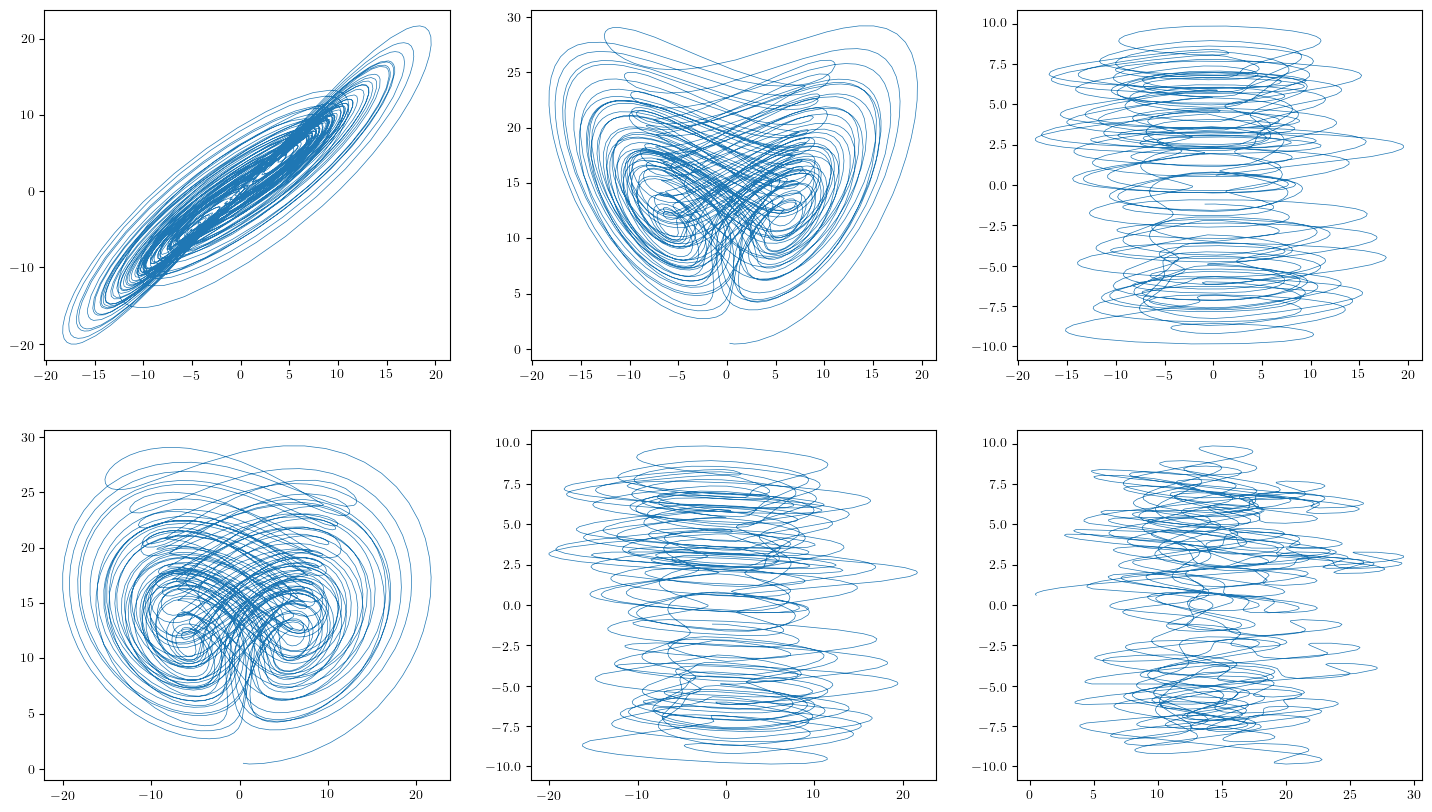

In [10]:
fig = mp.figure(figsize=(5*16/9*2, 5*2))
for i, (xdim, ydim) in enumerate(combinations(Z, 2)):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(xdim, ydim, lw=0.5)
# mp.tight_layout()
mp.show()

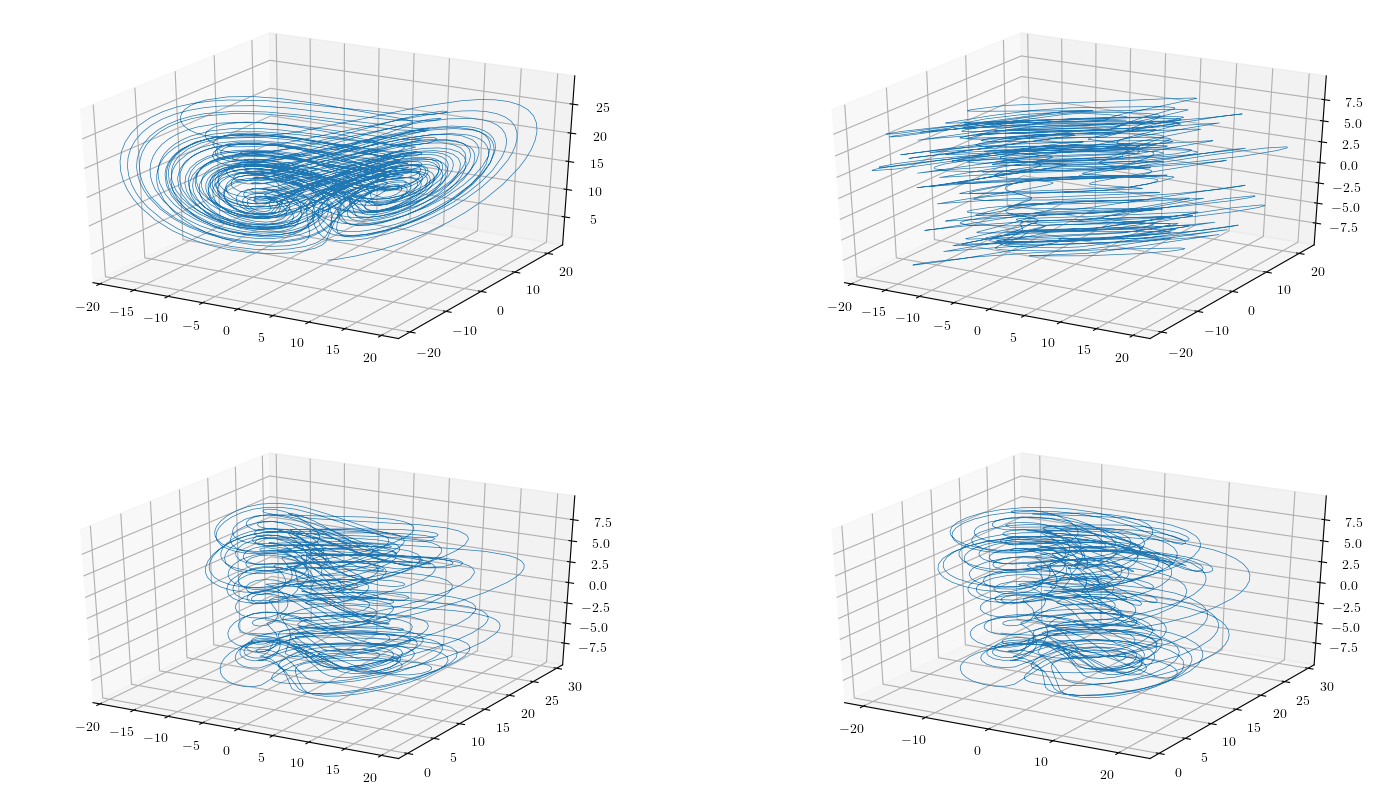

In [11]:
fig = mp.figure(figsize=(5*16/9*2, 5*2))
for i, (xdim, ydim, zdim) in enumerate(combinations(Z, 3)):
    ax = fig.add_subplot(2, 2, i+1, projection="3d")
    ax.plot(xdim, ydim, zdim, lw=0.5)
# mp.tight_layout()
mp.show()

A 1D signal $x$ in $R^N$ with length $N$ can be represented as

\begin{equation}
    \vec{x} = \sum_{j=1}^N \alpha_j \Psi_j = \vec{\Psi}\vec{\alpha}
\end{equation}

where

\begin{equation}
    \vec{\alpha} = \vec{\Psi}^T \vec{x}
\end{equation}

where $\vec{\Psi}$ is an $N \times N$ matrix and $\vec{\alpha} = [\alpha_1, \alpha_2, ..., \alpha_N]$ is the coefficient sequence of $\vec{x}$. If there are only $K$ (where $K << N$) coefficients in $\vec{\alpha}$ that are nonzero, the signal is compressible and sparse.

In [12]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10) 

In [15]:
X = img.imread("lena.png", mode="L")

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


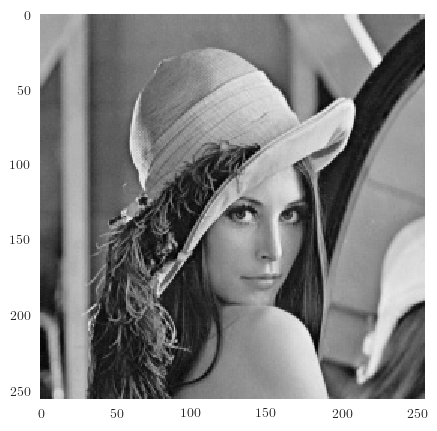

In [17]:
mp.imshow(X, cmap="gray")
mp.grid(False)
mp.show()

1) A sequence $\lambda = \left[ \lambda_1, \lambda_2, ..., \lambda_N \right]$ with length $2N$ is generated by logistic map with initial condition $x_{01}$. To obtain the index sequence $s = \left[ s_1, s_2, ..., s_N \right]$, the preceding $N$ elements of $\lambda$ are abandoned.

In [18]:
x01 = 0.11
x02 = 0.24
mu = 3.99

N = len(X)
lamda1 = [x01]
lamda2 = [x02]

for i in range(1, 2*N):
    lamda1.append(mu*lamda1[i-1]*(1 - lamda1[i-1]))
    lamda2.append(mu*lamda2[i-1]*(1 - lamda2[i-1]))
    
s1 = np.array(lamda1[N:])
s2 = np.array(lamda2[N:])

2) The nature sequence $n = \left[ n = 1, 2, ..., N \right]$ is sorted with the index sequence $s$ and the sorted sequence is noted as $l = \left[ l_1, l_2, ..., l_i, ..., l_N \right]$, where $l_i \in \left{ 1, 2, ..., N \right}$.

In [19]:
n = np.arange(0,N)
sorty1 = np.array([s1, n]).T
sorty2 = np.array([s2, n]).T
sorty1 = sorty1[sorty1[:,0].argsort()]
sorty2 = sorty2[sorty2[:,0].argsort()]
l1 = sorty1.T[1].astype("uint8")
l2 = sorty2.T[1].astype("uint8")

3) The $M$ row vectors $H(l_1,:), H(l_2,:), ..., H(l_M,:)$ of the Hadamard matrix $H$ of order N are used to group into the measurement matrix $\Phi_1 = \left[ H(l_1,:) H(l_2,:) ... H(l_M,:) \right]^T$, where $H(l_i.:)$ denotes the $l_i$-th row vector of $H$.

With another initial condition $x_{02}$, the measurement matrix $\Phi_2$ could be constructed in the same way.

In [20]:
M = 192
H = la.hadamard(N)
Phi1 = H[l1[:M]]
Phi2 = H[l2[:M]]

4) The original image $X$ is extended in the $\Psi$ domain and then performed the projection measurement in $\Phi_1$ to obtain $\beta_1 = \Phi_1 \Psi^T X$ where $\Phi_1$ is the $M \times N$ measurement matrix and $\Psi$ is the $N \times N$ orthogonal basis.

In [21]:
Psi = fft.dct(np.identity(N))
beta1 = Phi1.dot(Psi.T.dot(X))

5) Then $\beta_1$ is extended in the $\Psi$ domain to obtain $\beta_2 = \Psi^T X^T \Psi \Phi_1^T$, where measurement result $\beta = \Psi^T X^T \Psi$, which is the transform in the 2D $\Psi$ domain.

In [22]:
beta = Psi.T.dot(X.T.dot(Psi))
beta2 = Psi.T.dot(beta1.T)

6) By considering $Y = \Phi_2 \beta \Phi_1^T$, the intermediate encryption result $Y$ could be obtained by measuring $\beta$.

In [23]:
Y = Phi2.dot(beta.dot(Phi1.T))

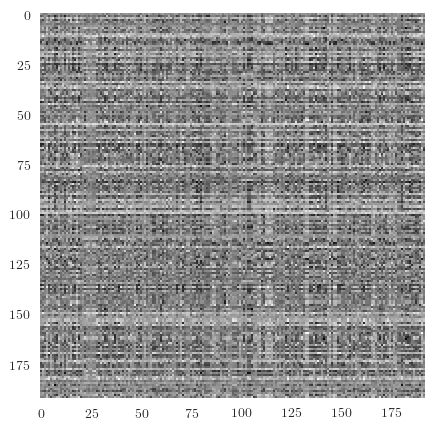

In [25]:
mp.imshow(Y, cmap="gray")
mp.grid(False)
mp.show()

In [26]:
ydir1 = SL0(Phi2, Y)

In [27]:
ydir2 = SL0(Phi1, ydir1.T)

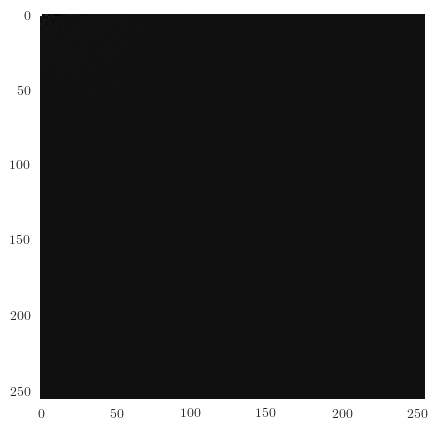

In [28]:
mp.imshow(ydir2, cmap="gray")
mp.grid(False)
mp.show()

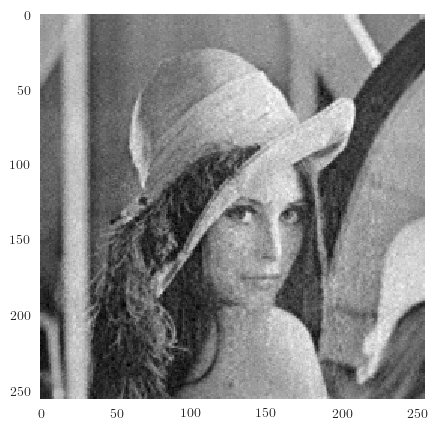

In [29]:
mp.imshow(idct2(ydir2), cmap="gray")
mp.grid(False)
mp.show()

7) Transform the four hyperchaotic sequences $x, y, z, h$ into integer sequences $t^*$, $t$ can be replaced by $x, y, z, h$.

\begin{equation}
    \left| \lfloor \left( t_i - \lfloor t_i \rfloor \right) \times 10^{14} \rfloor \right| \mod 224 
\end{equation}

In [43]:
M = 224

xs = (np.abs(np.floor((xi - np.floor(xi)) * 1e14)) % 224).astype("uint8")
ys = (np.abs(np.floor((yi - np.floor(yi)) * 1e14)) % 224).astype("uint8")
zs = (np.abs(np.floor((zi - np.floor(zi)) * 1e14)) % 224).astype("uint8")
hs = (np.abs(np.floor((hi - np.floor(hi)) * 1e14)) % 224).astype("uint8")

8) Construct a hyper-chaotic sequence $K = \left{ k_1, k_2, ..., k_{2^{2n}} \right}$. If the result of $h_i^* \mod 3$ equals 0, 1, or 2, then one takes $k_i$ as $x_i^*, y_i^*$, or $z_i^*$ correspondingly to perform the cycle shift operation.

In [44]:
n = 10
K = np.zeros(2**(2*n), "uint8")
for i in range(2**(2*n)):
    if hs[i]%3 == 0:
        K[i] = xs[i]
    elif hs[i]%3 == 1:
        K[i] = ys[i]
    else:
        K[i] = zs[i]

9) The pseudorandom sequence generated by the hyper-chaotic system is transformed as $R_2 = \left{ R_2 \Big| R_{2i} = \textrm{round} \left( 10000y_i \mod 8 \right) \right}$, where $i = 0, 1, 2...$.

In [45]:
R2 = np.round((10000*yi)%8).astype("uint8")

10) All pixels of $Y$ are mapped into an integer range from 0 to 255

\begin{equation}
    C = \textrm{round} \left[ 255 \times \frac{Y}{\max Y} \right]
\end{equation}

In [46]:
C = np.round(255 * Y/np.max(Y)).astype("uint8")

11) Each pixel in $C$ is decomposed into an 8-bit binary number

\begin{align}
    a^t(i,j) = && 1, && \frac{a(i,j)}{2^t} \mod 2 = 1 \\
                && 0, && \textrm{ otherwise}
\end{align}

where $a^t(i,j)$ is the $t$-th number after conversion, $t = 0, 1, 2, ..., 7$. The results are arranged in a row in turn, and the size of the transformed matrix $D$ is $8M^2$.

In [47]:
D = np.zeros((8,M**2), "uint8")

for i in range(C.size):
    for t in range(8):
        if t >= len(str(C.flat[i])):
            D.T.flat[i] = 0
        else:
            if int(str(C.flat[i])[t])%2 == 1:
                D.T.flat[i] = 1
            else:
                D.T.flat[i] = 0

12) Disturb the pixel values of the matrix with the cycle shift operation and the pseudorandom sequence $R_2$.

\begin{equation}
    C' = T(D_{8\times M^2}, R_2)
\end{equation}

In [48]:
C.flat[0]

161

In [49]:
D.T[0].tolist()

[0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
format(161, "b")

'10100001'